# **Importing required packages**

In [1]:
import pandas as pd # reading all required header files
import numpy as np
import random
import operator
import math
import matplotlib.pyplot as plt 
from scipy.stats import multivariate_normal 
from sklearn.datasets import load_iris
import warnings
warnings.filterwarnings('ignore')

C:\Users\sasne\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):


# **Load Dataset**

In [2]:
"""
from google.colab import files
uploaded = files.upload()
df_full = pd.read_csv('Iris.csv')
df = df_full.drop(columns=['Id'])
df.shape
df.head()
df = df.drop(columns=['Species'])
df.head()
"""

# iris = load_iris()
# df = pd.DataFrame(iris.data)
# y = df.iloc[:,-1]
col_names = ["SepalLengthCm",  "SepalWidthCm", "PetalLengthCm","PetalWidthCm", "Class"]
data = pd.read_csv('iris.csv')

df = data.iloc[:,0:4]
y = data.iloc[:,-1]

In [3]:
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm
0,1,5.1,3.5,1.4
1,2,4.9,3.0,1.4
2,3,4.7,3.2,1.3
3,4,4.6,3.1,1.5
4,5,5.0,3.6,1.4


# **Defining parameters**

Data = { x<sub>1</sub>, x<sub>2</sub>, ... , x<sub>n</sub> }
<br>
Cluster = { C<sub>1</sub>, C<sub>2</sub>, ... , C<sub>k</sub> }

n = number of data<br>
k = number of clusters<br>
d = dimension of data<br>
m = fuzzy parameter


In [4]:
#number of data
n = len(df)

#number of clusters
k = 3

#dimension of cluster
d = 4

# m parameter
m = 2

#number of iterations
MAX_ITERS = 12


# **Visualizing Data**

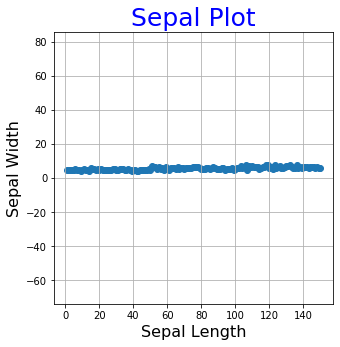

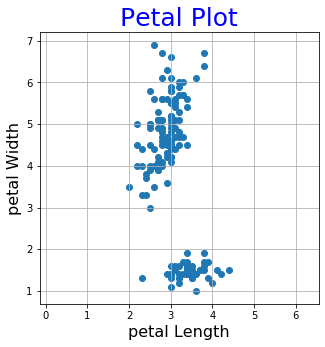

In [5]:
plt.figure(0,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df.iloc[:,0]), list(df.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=25,color='b')                                            
plt.grid()                                                    
plt.show()

plt.figure(1,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('petal Length', fontsize=16)                                                 
plt.ylabel('petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=25,color='b')                                            
plt.grid()                                                                 
plt.show()

# **Initializing Membership Matrix**

### <b>w<sub>ij</sub></b> values are assigned randomly.

In [6]:
def initializeMembershipWeights():
  """
  membership_mat = []
  for i in range(n):
    wts = []
    sum=0;
    for j in range(k):
      weight = np.random.random_integers(1,10)
      wts.append(weight)
      sum = sum + weight
    weights = [w/sum for w in wts]
    membership_mat.append(weights)
    print(membership_mat)

    """
  weight = np.random.dirichlet(np.ones(k),n)
  weight_arr = np.array(weight)
  return weight_arr

# **Calculating Cluster Center**

### To calculate centroids for each cluster we apply the following formula:

## C<sub>j</sub> = $ \frac{\sum_{i=1}^{n} W_{ij}^m x_{i}}{\sum_{i=1}^{n} W_{ij}^m} $

### m(fuzzy-ness) ranges from 1 to $\infty$

In [7]:
def computeCentroids(weight_arr):
    C = []
    for i in range(k):
        weight_sum = np.power(weight_arr[:,i],m).sum()
        Cj = []
        for x in range(d):
            numerator = ( df.iloc[:,x].values * np.power(weight_arr[:,i],m)).sum()
            c_val = numerator/weight_sum;
            Cj.append(c_val)
        C.append(Cj)
    return C

# **Updating Membership Value**

### Calculate the fuzzy-pseudo partition with the above formula
## $$w_{ij} = \frac{(\frac{1}{dist(x_i, c_j)})^{\frac{1}{m-1}}}{\sum_{s=1}^{k}(\frac{1}{dist(x_i,c_s)})^{\frac{1}{m-1}}}w 
ij$$


### where $dist (x_i, c_j)$ is the Euclidean distance between $x_{i}$ and $c_{j}$ cluster center.

In [8]:
def get_euclidean_dist(single_data_pnt, centroid):
    p = 1 / (m - 1);
    dist = (df.iloc[single_data_pnt, :].values - centroid)**2
    dist = np.sqrt(dist) 
    dist = np.power(np.divide(1, dist).sum(), p)
    return dist

In [9]:
# def updateWeights(weight_arr,C):
#     euclidean_dist = []
#     for data_point in range(n):
#         row = []  
#         for cluster in range(k):
#             row.append(get_euclidean_dist(data_point, C[cluster]))
#         euclidean_dist.append(row)

#     # Calculate denominator
#     new_uij = []
#     for data_point in range(n):
#         row = []
#         for cluster in range(k):
#             numerator = euclidean_dist[data_point][cluster]
#             denom = sum(euclidean_dist[data_point])
#             dist = numerator/denom
#             row.append(dist)
#         new_uij.append(row)
#     return new_uij
def updateWeights(weight_arr,C):
    denom = np.zeros(n)
    for j in range(k):
        dist = (df.iloc[:,:].values - C[j])**2
        dist = np.sum(dist, axis=1)
        dist = np.sqrt(dist)
        denom  = denom + np.power(1/dist,1/(m-1))

    for s in range(k):
        dist = (df.iloc[:,:].values - C[s])**2
        dist = np.sum(dist, axis=1)
        dist = np.sqrt(dist)
        weight_arr[:,s] = np.divide(np.power(1/dist,1/(m-1)),denom)
    return weight_arr

# **Plot data for visualizing algorithm**

In [10]:
def plotData(z,C):  
    plt.subplot(4,3,z+1)              #scatter plot of Petal length vs Petal width                              
    plt.scatter(list(df.iloc[:,2]), list(df.iloc[:,3]), marker='o')    
    for center in C:
        plt.scatter(center[2],center[3], marker='o',color='r')        
    plt.axis('equal')                                                                 
    plt.xlabel('Petal Length', fontsize=18)                                                 
    plt.ylabel('Petal Width', fontsize=18)                                                                                      
    plt.grid()    

# **Fuzzy algorithm**

In [11]:
def getClusters(membership_mat): # getting the clusters
    cluster_labels = list()
    for i in range(n):
        max_val, idx = max((val, idx) for (idx, val) in enumerate(membership_mat[i]))
        cluster_labels.append(idx)
    return cluster_labels

In [12]:
def FuzzyMeansAlgorithm():
    weight_arr = initializeMembershipWeights()
    
    plt.figure(figsize=(30,30))
    acc=[]
    for z in range(MAX_ITERS):
        C = computeCentroids(weight_arr)
        weight_arr = updateWeights(weight_arr,C)
        cluster_labels = getClusters(weight_arr)
        acc.append(cluster_labels)
        plotData(z,C)
    plt.show()
    return (weight_arr, C, acc, cluster_labels)

# **Running algorithm**

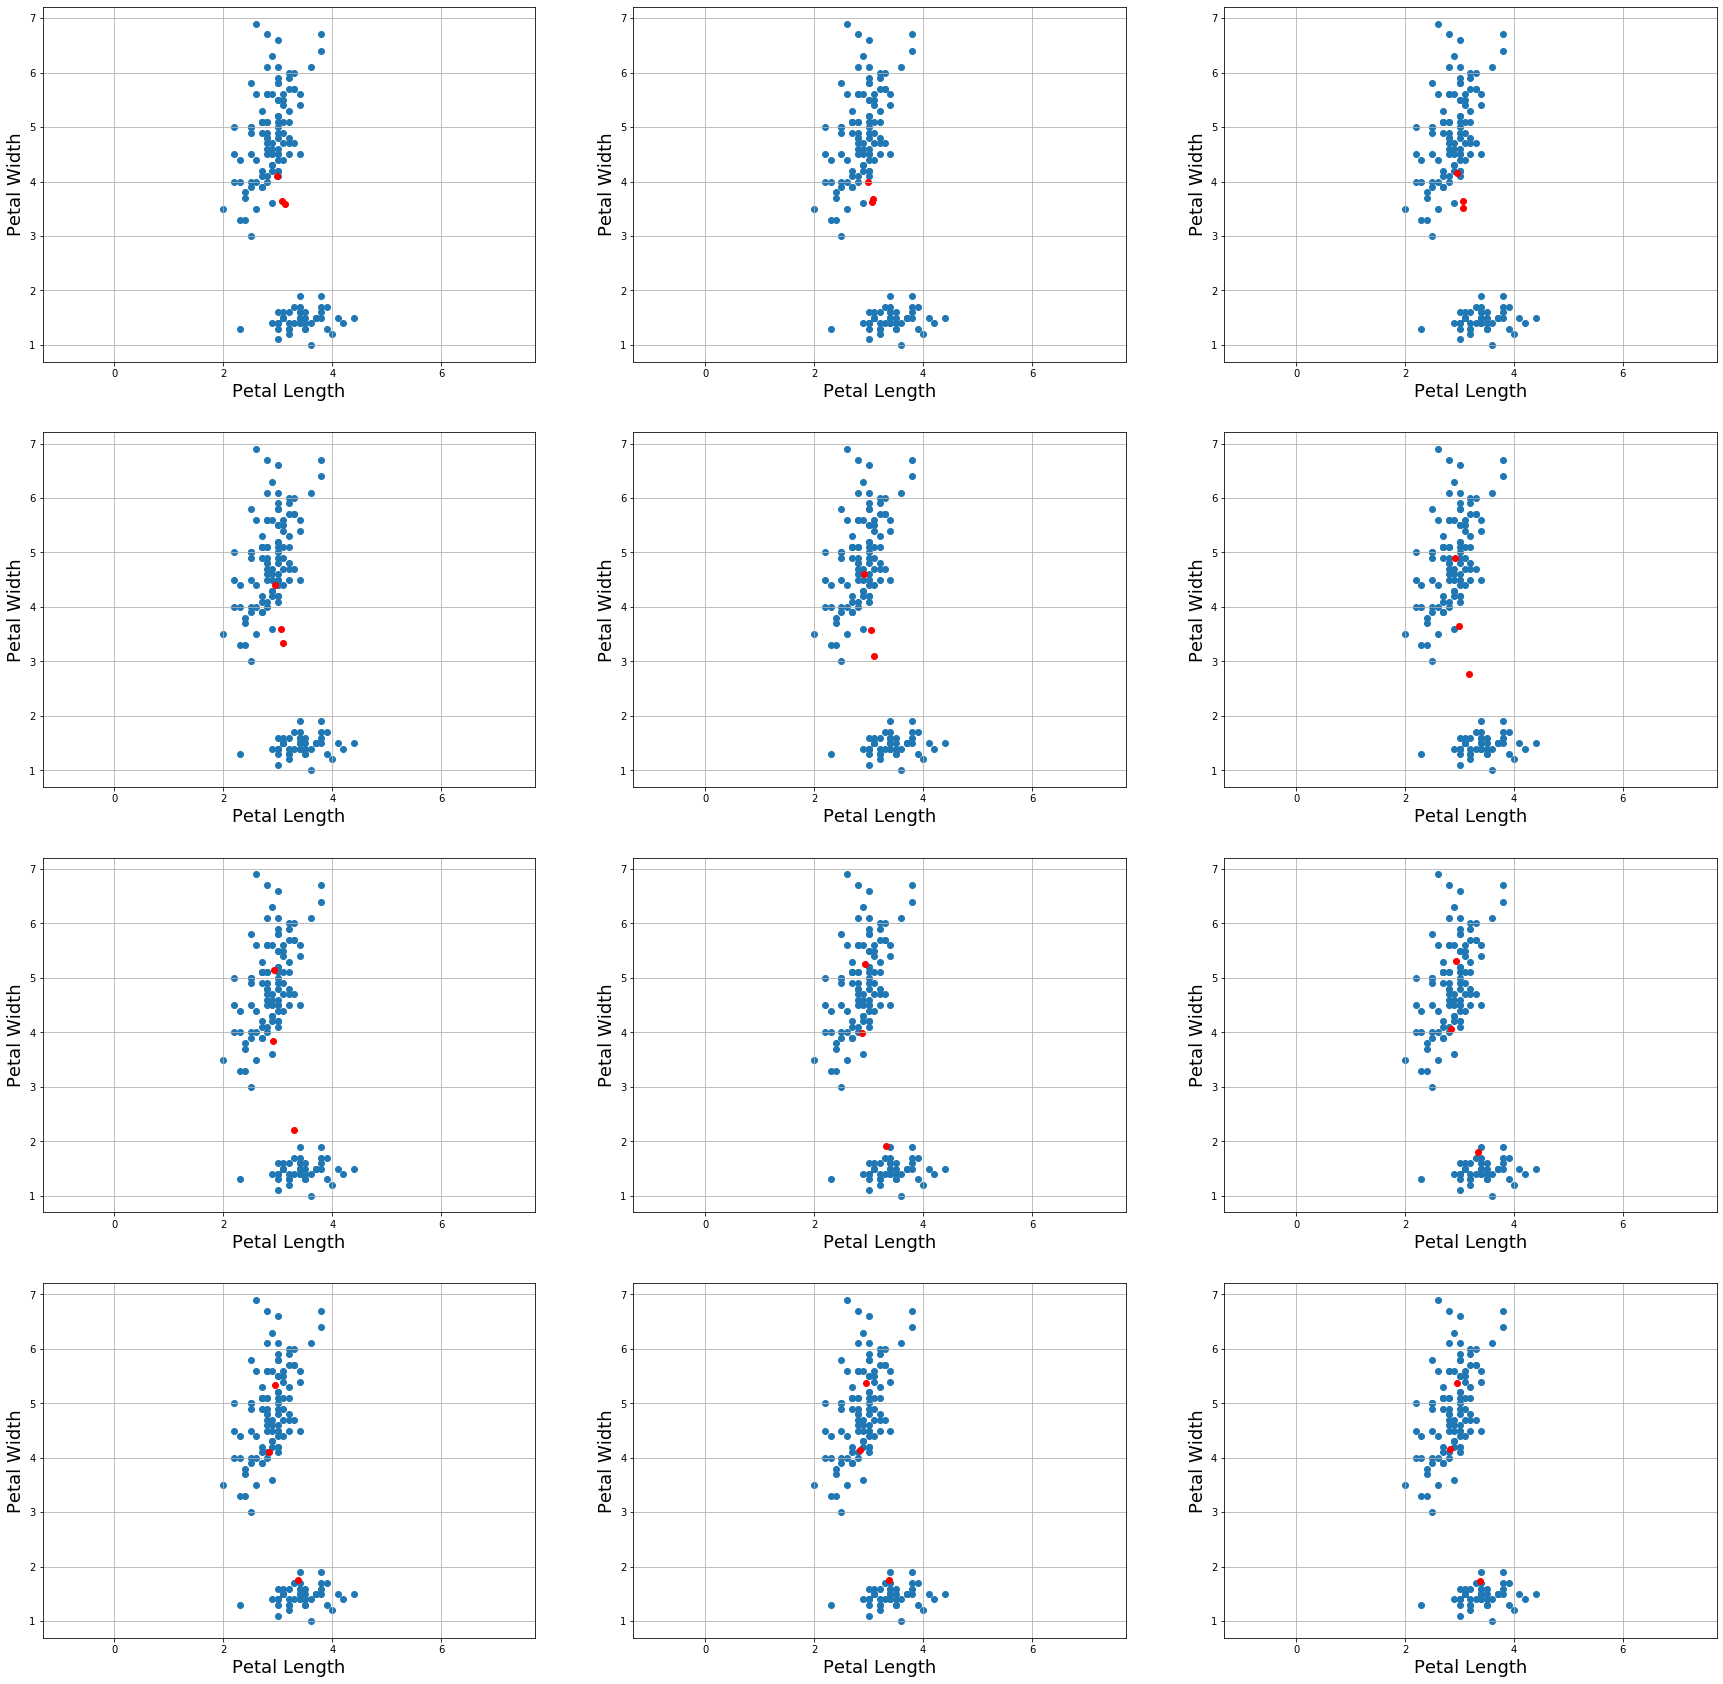

In [13]:
final_weights, Centers, acc, labels = FuzzyMeansAlgorithm()

# **Visualizing Cluster final centers**

In [14]:
df_sepal = df.iloc[:,0:2]
df_petal = df.iloc[:,2:5]

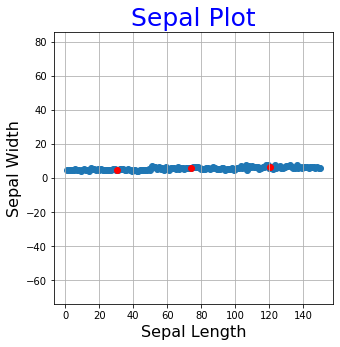

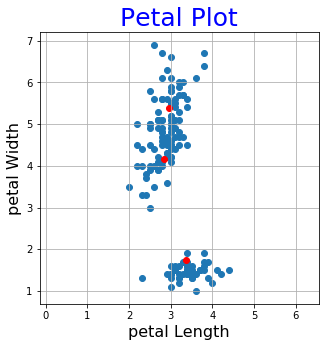

In [15]:
plt.figure(0,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df_sepal.iloc[:,0]), list(df_sepal.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=25,color='b')                                            
plt.grid() 
for center in Centers:
    plt.scatter(center[0],center[1], marker='o',color='r')                                                                
plt.show()

plt.figure(1,figsize=(5,5))                #scatter plot of sepal length vs sepal width                              
plt.scatter(list(df_petal.iloc[:,0]), list(df_petal.iloc[:,1]), marker='o')       
plt.axis('equal')                                                                 
plt.xlabel('petal Length', fontsize=16)                                                 
plt.ylabel('petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=25,color='b')                                            
plt.grid()                     
for center in Centers:
    plt.scatter(center[2],center[3], marker='o',color='r')                                                       
plt.show()

# **Visualizing clusters** 

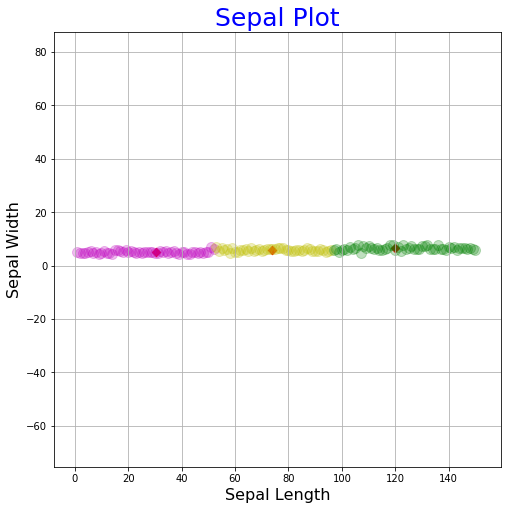

In [16]:
X = np.zeros((n,1))
plt.figure(0,figsize=(8,8))                #scatter plot of sepal length vs sepal width                                     
plt.axis('equal')                                                                 
plt.xlabel('Sepal Length', fontsize=16)                                                 
plt.ylabel('Sepal Width', fontsize=16)                                                 
plt.title('Sepal Plot', fontsize=25,color='b')                                            
plt.grid() 
for center in Centers:
    plt.scatter(center[0],center[1], marker='D',color='r')                                                                
clr = 'b'
for i in range(n):    
    cNumber = np.where(final_weights[i] == np.amax(final_weights[i]))
    if cNumber[0][0]==0:
        clr = 'y'
    elif cNumber[0][0]==1:
        clr = 'g'
    elif cNumber[0][0]==2:
        clr = 'm'#color
    plt.scatter(list(df_sepal.iloc[i:i+1,0]), list(df_sepal.iloc[i:i+1,1]), alpha=0.25,s=100,color=clr)
plt.show()


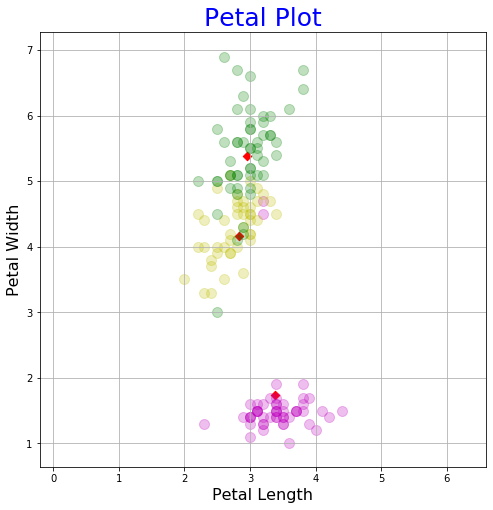

In [17]:
X = np.zeros((n,1))
plt.figure(0,figsize=(8,8))                #scatter plot of sepal length vs sepal width                                     
plt.axis('equal')                                                                 
plt.xlabel('Petal Length', fontsize=16)                                                 
plt.ylabel('Petal Width', fontsize=16)                                                 
plt.title('Petal Plot', fontsize=25,color='b')                                            
plt.grid() 
for center in Centers:
    plt.scatter(center[2],center[3], marker='D',color='r')                                                                
clr = 'b'
for i in range(n):    
    cNumber = np.where(final_weights[i] == np.amax(final_weights[i]))
    if cNumber[0][0]==0:
        clr = 'y'
    elif cNumber[0][0]==1:
        clr = 'g'
    elif cNumber[0][0]==2:
        clr = 'm'
    plt.scatter(list(df_petal.iloc[i:i+1,0]), list(df_petal.iloc[i:i+1,1]), alpha=0.25, s=100, color=clr)
plt.show()

### Calculating Accuracy

In [18]:
def accuracy(cluster_labels, class_labels):
    correct_pred = 0
    seto = max(set(labels[0:50]), key=labels[0:50].count)
    vers = max(set(labels[50:100]), key=labels[50:100].count)
    virg = max(set(labels[100:]), key=labels[100:].count)
    
    for i in range(len(df)):
        if cluster_labels[i] == seto and class_labels[i] == 'Iris-setosa':
            correct_pred = correct_pred + 1
        if cluster_labels[i] == vers and class_labels[i] == 'Iris-versicolor' and vers!=seto:
            correct_pred = correct_pred + 1
        if cluster_labels[i] == virg and class_labels[i] == 'Iris-virginica' and virg!=seto and virg!=vers:
            correct_pred = correct_pred + 1
            
    accuracy = (correct_pred/len(df))*100
    return accuracy

In [19]:
acc_lis = [] 
for i in range(0,len(acc)):
    val = accuracy(acc[i], y)
    acc_lis.append(val)

In [20]:
print("Accuracy => ", max(acc_lis))

Accuracy =>  96.66666666666667
